In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from helpers.load_data import load_leads_with_deals
from helpers import model_deploy as md

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    classification_report,
)
from imblearn.ensemble import BalancedRandomForestClassifier

In [ ]:
df_leads_deals = load_leads_with_deals()

df_leads_deals = df_leads_deals[["mql_id" , "first_contact_date" , "landing_page_id" , "origin" , "conversed_lead" ]].copy()

df_leads_deals["first_contact_year"] = df_leads_deals["first_contact_date"].dt.year
df_leads_deals["first_contact_month"] = df_leads_deals["first_contact_date"].dt.month
df_leads_deals["first_contact_day"] = df_leads_deals["first_contact_date"].dt.day
df_leads_deals["first_contact_weekday"] = df_leads_deals["first_contact_date"].dt.day_name()


df_leads_deals_dummies = pd.get_dummies(df_leads_deals, columns=["landing_page_id", "origin", "first_contact_weekday"])
df_ordered = df_leads_deals_dummies.sort_values("first_contact_date").reset_index(drop=True)

In [3]:
# finding the best hyperparameters 

tscv = TimeSeriesSplit(n_splits=5)

X = df_ordered.drop(columns=["conversed_lead", "mql_id", "first_contact_date"])
y = df_ordered["conversed_lead"]

param_grid = {
    "n_estimators": [50, 100, 200, 300, 400, 500],
    "max_depth": [3, 5, 7, 9, 12, 15],
    "min_samples_leaf": [5, 10, 15, 20]
}

grid = GridSearchCV(
    BalancedRandomForestClassifier(),
    param_grid,
    cv=tscv,
    scoring="f1",
    n_jobs=-1
)

grid.fit(X, y)
print(grid.best_params_)


{'max_depth': 9, 'min_samples_leaf': 10, 'n_estimators': 50}


In [4]:
def build_model():
    return BalancedRandomForestClassifier(
        n_estimators=50,
        max_depth=5,
        min_samples_leaf=15,
        sampling_strategy="auto",
        random_state=42,
        n_jobs=-1,
    )

In [5]:
X = df_ordered.drop(columns=["conversed_lead", "mql_id"])
y = df_ordered["conversed_lead"]

tscv = TimeSeriesSplit(n_splits=5)

fold_metrics = []
feature_importances = []

for fold, (train_index, test_index) in enumerate(tscv.split(X), start=1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    train_range = (X_train["first_contact_date"].min(), X_train["first_contact_date"].max())
    test_range = (X_test["first_contact_date"].min(), X_test["first_contact_date"].max())

    X_train_model = X_train.drop(columns="first_contact_date")
    X_test_model = X_test.drop(columns="first_contact_date")

    clf = build_model()

    clf.fit(X_train_model, y_train)

    y_pred = clf.predict(X_test_model)
    y_proba = clf.predict_proba(X_test_model)[:, 1]

    fold_metrics.append(
        {
            "fold": fold,
            "train_start": train_range[0],
            "train_end": train_range[1],
            "test_start": test_range[0],
            "test_end": test_range[1],
            "accuracy": accuracy_score(y_test, y_pred),
            "balanced_accuracy": balanced_accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred, zero_division=0),
            "recall": recall_score(y_test, y_pred, zero_division=0),
            "f1": f1_score(y_test, y_pred, zero_division=0),
            "roc_auc": roc_auc_score(y_test, y_proba),
        }
    )

    feature_importances.append(clf.feature_importances_)

    print(f"Fold {fold}: train {train_range[0]} → {train_range[1]} | test {test_range[0]} → {test_range[1]}")
    print(classification_report(y_test, y_pred, zero_division=0))
    print("-" * 60)

cv_results = pd.DataFrame(fold_metrics)
print("Cross Validation metrics:")
display(cv_results)

cv_summary = cv_results.describe().loc[["mean", "std"]]
print("Cross Validation Summary:")
display(cv_summary)

feature_importance_df = pd.DataFrame(
    np.mean(feature_importances, axis=0),
    index=X_train_model.columns,
    columns=["mean_importance"],
).sort_values("mean_importance", ascending=False)
print("Feature Importance")
display(feature_importance_df.head(15))


Fold 1: train 2017-06-14 00:00:00 → 2017-10-30 00:00:00 | test 2017-10-30 00:00:00 → 2018-01-19 00:00:00
              precision    recall  f1-score   support

         0.0       0.86      0.46      0.60      1216
         1.0       0.04      0.26      0.07       117

    accuracy                           0.44      1333
   macro avg       0.45      0.36      0.34      1333
weighted avg       0.79      0.44      0.55      1333

------------------------------------------------------------
Fold 2: train 2017-06-14 00:00:00 → 2018-01-19 00:00:00 | test 2018-01-19 00:00:00 → 2018-02-25 00:00:00
              precision    recall  f1-score   support

         0.0       0.95      0.02      0.03      1145
         1.0       0.14      0.99      0.25       188

    accuracy                           0.16      1333
   macro avg       0.55      0.51      0.14      1333
weighted avg       0.84      0.16      0.06      1333

------------------------------------------------------------
Fold 3: train 

,fold,train_start,train_end,test_start,test_end,accuracy,balanced_accuracy,precision,recall,f1,roc_auc
0,1,2017-06-14,2017-10-30,2017-10-30,2018-01-19,0.440360,0.357235,0.043541,0.256410,0.074442,0.352993
1,2,2017-06-14,2018-01-19,2018-01-19,2018-02-25,0.155289,0.506074,0.142530,0.994681,0.249333,0.600743
2,3,2017-06-14,2018-02-25,2018-02-25,2018-03-30,0.258065,0.538451,0.154978,0.932292,0.265776,0.593636
3,4,2017-06-14,2018-03-30,2018-03-30,2018-04-30,0.279070,0.555302,0.149642,0.932961,0.257915,0.676304
4,5,2017-06-14,2018-04-30,2018-04-30,2018-05-31,0.402101,0.614610,0.131257,0.880597,0.228461,0.686754


Cross Validation Summary:


,fold,train_start,train_end,test_start,test_end,accuracy,balanced_accuracy,precision,recall,f1,roc_auc
mean,3.000000,2017-06-14 00:00:00,2018-02-13 09:36:00,2018-02-13 09:36:00,2018-03-28 00:00:00,0.306977,0.514334,0.12439,0.799388,0.215185,0.582086
std,1.581139,NaN,NaN,NaN,NaN,0.115130,0.096260,0.04606,0.306212,0.079900,0.134905


Feature Importance


,mean_importance
first_contact_month,0.251949
origin_email,0.075864
landing_page_id_22c29808c4f815213303f8933030604c,0.067103
first_contact_year,0.061117
first_contact_day,0.059710
first_contact_weekday_Wednesday,0.055405
origin_organic_search,0.043139
landing_page_id_40dec9f3d5259a3d2dbcdab2114fae47,0.042984
origin_paid_search,0.037197
landing_page_id_b76ef37428e6799c421989521c0e5077,0.035438


Hold-out metrics:
          accuracy: 0.432
 balanced_accuracy: 0.614
         precision: 0.129
            recall: 0.840
                f1: 0.224
           roc_auc: 0.691


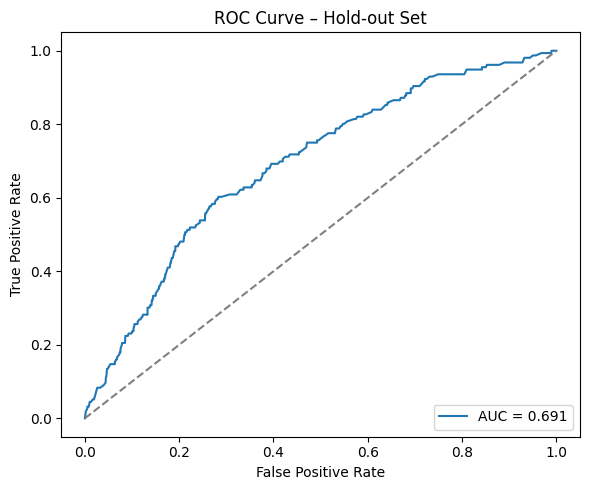

,first_contact_date,actual,predicted,probability
6400,2018-04-24,False,1.0,0.502507
6401,2018-04-24,False,0.0,0.483884
6402,2018-04-24,True,1.0,0.502507
6403,2018-04-24,False,1.0,0.503975
6404,2018-04-24,False,1.0,0.523449
6405,2018-04-24,False,0.0,0.497893
6406,2018-04-24,True,1.0,0.521956
6407,2018-04-24,True,1.0,0.532222
6408,2018-04-24,True,1.0,0.506874
6409,2018-04-24,False,0.0,0.483884


In [6]:
split_idx = int(len(df_ordered) * 0.8)


train_df = df_ordered.iloc[:split_idx].copy()
test_df = df_ordered.iloc[split_idx:].copy()


X_train = train_df.drop(columns=["conversed_lead", "mql_id"])
y_train = train_df["conversed_lead"]
X_test = test_df.drop(columns=["conversed_lead", "mql_id"])
y_test = test_df["conversed_lead"]

# Keep the date column for reporting but exclude from the model
X_train_model = X_train.drop(columns="first_contact_date")
X_test_model = X_test.drop(columns="first_contact_date")

clf = build_model()
clf.fit(X_train_model, y_train)

y_pred = clf.predict(X_test_model)
y_proba = clf.predict_proba(X_test_model)[:, 1]


metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "balanced_accuracy": balanced_accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred, zero_division=0),
    "recall": recall_score(y_test, y_pred, zero_division=0),
    "f1": f1_score(y_test, y_pred, zero_division=0),
    "roc_auc": roc_auc_score(y_test, y_proba),
}
print("Hold-out metrics:")
for name, value in metrics.items():
    print(f"{name:>18}: {value:.3f}")

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {metrics["roc_auc"]:.3f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Hold-out Set")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Preview predictions vs actuals
test_results = (
    X_test.assign(
        actual=y_test.values,
        predicted=y_pred,
        probability=y_proba,
    )
    .loc[:, ["first_contact_date", "actual", "predicted", "probability"]]
)
display(test_results.head(20))

In [7]:
md.save_model(clf, "models/conversion_prediction_v0")